# COMPSCI 389: Homework 5


### Overview

In this assignment we will implement the MENACE algorithm and plot a **learning curve** that characterizes how it learns.

### Step 1: Import Statements

Let's begin with the import statements that we will use. 

In [5]:
import random
import time
import matplotlib.pyplot as plt
import numpy as np

### Step 2: Implementing Tic-Tac-Toe (Naughts and Crosses)

In this section we implement tic-tac-toe. 

We will represent the board as a $3 \times 3$ matrix with values 'X', 'O', or ' ' (empty). First, let's write a function to print the board.

In [7]:
def print_board(board):
    for row in board:
        print(" | ".join(row))
        print("-" * 5)

Next, let's write a function to check for a winner. This function returns 'X', 'O', 'Draw', or None (game still in progress). It works by creating a tuple of tuples (array of arrays) `lines`. Each element of `lines` is an array of length 3 containing the pieces (X, Y, empty) along one possible line where a player could get three pieces in a row. Once this tuple of tuples has been created, it loops over `lines` to check whether any of these contain the same value (that isn't ' ', which denotes empty). If there are now winners yet, it checks whether there are any empty squares. If so, the game is not yet over. If there are no empty squares, the game is a draw.

In [9]:
def check_winner(board):
    # Load lines with all of the sequences on the board where a player could get three in a row
    lines = (
        # Horizontal lines
        board[0], board[1], board[2],
        # Vertical lines
        [board[0][0], board[1][0], board[2][0]], 
        [board[0][1], board[1][1], board[2][1]], 
        [board[0][2], board[1][2], board[2][2]],
        # Diagonals
        [board[0][0], board[1][1], board[2][2]], 
        [board[2][0], board[1][1], board[0][2]]
    )

    # Loop over all of these lines
    for line in lines:
        # Check whether all three elements in this line are the same, and not empty
        if line[0] == line[1] == line[2] and line[0] != ' ':
            # There is a winner! Return the winner, ('X' or 'O')
            return line[0]
    
    # Check for a draw (no empty squares)
    if all(all(cell != ' ' for cell in row) for row in board):
        return 'Draw'
    
    # The game isn't over yet!
    return None

Next, let's write functions:
- `valid_moves`: Returns a list of all empty spaces where plpayers can make a move. Each element of this list is an $(i,j)$ tuple.
- `make_move`: Updates the board with the player's move if the chosen position is empty. It returns `True` on success and `False` on failure (we will use this for error checking).
- `initialize_board`: Generates a $3 \times 3$ tic-tac-toe board initialized with empty spaces.

In [11]:
def valid_moves(board):
    return [(i, j) for i in range(3) for j in range(3) if board[i][j] == ' ']

def make_move(board, move, player):
    i, j = move
    if board[i][j] == ' ':
        board[i][j] = player
        return True
    return False

def initialize_board():
    return [[' ' for _ in range(3)] for _ in range(3)]

### Step 3: Implementing Players

We will create a class for "players". One player will be MENACE, another will select moves randomly. Below is the implementation of the base class. It has three functions:

- `get_move`: Presents the player with a board and asks for a move. The `symbol` is an additional argument saying which symbol, X or O, the player is playing as.
- `learn`: This is called at the end of a game and has the games result. The player can use this to change its policy. Like `get_move`, this function also takes `symbol` as an argument, telling the player which symbol it was playing as.
- `reset`: This is used to reset the agent so that multiple trials can be run.

In [13]:
class Player:
    def get_move(self, board, symbol):
        raise NotImplementedError("This method should be overridden by subclasses")
    
    def learn(self, result, symbol):
        raise NotImplementedError("This method should be overridden by subclasses")
    
    def reset(self):
        raise NotImplementedError("This method should be overridden by subclasses")


Here is the `RandomPlayer` class, which always selects moves uniformly randomly from the legal moves.

In [15]:
class RandomPlayer(Player):
    def get_move(self, board, symbol):
        moves = valid_moves(board)
        return random.choice(moves)
    
    def learn(self, result, symbol):
        pass  # Random player does not learn
    
    def reset(self):
        pass  # No state to reset

### Step 4: Playing a Game

Next we provide code to play a game. This function takes as input two players (e.g., the `random_player` function that we wrote), and has the players play one game. It returns the winner, with the first player being 'X' and the second player being 'O'.

In [17]:
def play_game(player1, player2):
    # Start with blank initial board
    board = initialize_board()

    # Store the current and next player. These will be swapped after each turn
    current_player, next_player = player1, player2

    # Also store the current and next symbol (also swapper after each turn).
    current_symbol, next_symbol = 'X', 'O'
    
    # Loop over time (moves)
    while True:
        # Query the current player for a move
        move = current_player.get_move(board, current_symbol)

        # Make the move
        if not make_move(board, move, current_symbol):
            # Handle illegal or failed moves. Print something to help with debugging this case!
            print(f"WARNING: Illegal move by {current_symbol}.")
            current_player.learn('Loss', current_symbol)
            next_player.learn('Win', next_symbol)
            return next_symbol  # Opponent wins if illegal move

        # Check whether the game is over
        winner = check_winner(board)
        if winner:
            # If we get here, the game is over. Call the "learn" functions
            if winner == 'Draw':
                player1.learn('Draw', 'X')
                player2.learn('Draw', 'O')
            else:
                player1.learn('Win' if winner == 'X' else 'Loss', 'X')
                player2.learn('Win' if winner == 'O' else 'Loss', 'O')
            return winner
        
        # Swap players and symbols for the next turn
        current_player, next_player = next_player, current_player
        current_symbol, next_symbol = next_symbol, current_symbol

### Step 5: Running and Experiment

Next we code to have two players play `games_per_trial` games against each other. Right now the players don't learn, but when we implement MENACE we expect it to learn during these games. However, playing this number of games might give different results if we ran it many times. To capture this, we repeat this process `num_trials` times, storing the results.

That is, the players play `num_trials` sequences of `games_per_trial` against each other, and the outcomes of all games are stored.

The results that are returned are *rewards* from the perspective of `player1`. The rewards are (again, from `player1`'s perspective):
- Win: +3
- Loss: -1
- Draw: +1

In [19]:
def run_trials(num_trials, games_per_trial, player1, player2):
    # Create a matrix where we will store the results. It has num_trials rows and games_per_trial cols
    results_matrix = np.zeros((num_trials, games_per_trial))

    # Loop over the trials
    for trial in range(num_trials):
        # Reset the players so they learn from scratch
        player1.reset()
        player2.reset()

        # Loop over games in this trial
        for game in range(games_per_trial):
            # Have player1 go first for even trials and player2 go first for odd trials
            if game % 2 == 0:
                result = play_game(player1, player2)
                reward = 3 if result == 'X' else 1 if result == 'Draw' else -1
            else:
                result = play_game(player2, player1)
                reward = 3 if result == 'O' else 1 if result == 'Draw' else -1
            
            # Log the result as a reward value
            results_matrix[trial, game] = reward
    
    # Return the computed results
    return results_matrix

### Step 6: Plotting the Results

Next, we provide code to plot the results. This will be a plot with the number of games played on the horizontal axis and the resulting reward on the vertical axis. We will average the results from the `num_trials` trials that are run, and will include standard-error error bars.

**Note**: To reduce the number of points plotted, this plots a point ever 100 games. Each point reports the average reward over the last 100 games.

**Note**: We also include a red dashed line at 1.0, which corresponds to roughly the value achieved when neither agent learns. MENACE should be able to improve upon this line.

In [21]:
def plot_learning_curve(results_matrix):
    # Calculate the mean rewards and standard errors across trials for each game
    mean_rewards = np.mean(results_matrix, axis=0)
    standard_errors = np.std(results_matrix, axis=0) / np.sqrt(results_matrix.shape[0])
    games = np.arange(1, results_matrix.shape[1] + 1)

    # Averaging over intervals of 100 games
    interval = 100
    num_intervals = (len(mean_rewards) + interval - 1) // interval
    averaged_means = []
    averaged_errors = []
    averaged_games = []

    for i in range(num_intervals):
        start_index = i * interval
        end_index = min(start_index + interval, len(mean_rewards))
        
        # Calculate the mean of means and the mean of errors for the interval
        interval_means = mean_rewards[start_index:end_index]
        interval_errors = standard_errors[start_index:end_index]

        averaged_means.append(np.mean(interval_means))
        averaged_errors.append(np.mean(interval_errors))
        averaged_games.append(np.mean(games[start_index:end_index]))

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(averaged_games, averaged_means, '-', label='Average Reward', color='blue')
    plt.fill_between(averaged_games, np.array(averaged_means) - np.array(averaged_errors), np.array(averaged_means) + np.array(averaged_errors), color='lightblue', alpha=0.5)
    plt.title('Learning Curve over Multiple Trials')
    plt.xlabel('Game Number')
    plt.ylabel('Average Reward')
    plt.axhline(y=1, color='red', linestyle='--', label='No Learning Benchmark')
    plt.ylim(-1.5, 3.5)
    plt.legend()
    plt.grid(True)
    plt.show()

### Step 7: Example Run

Here is how we can run this code to obtain a **learning curve** for the random player playing against itself:

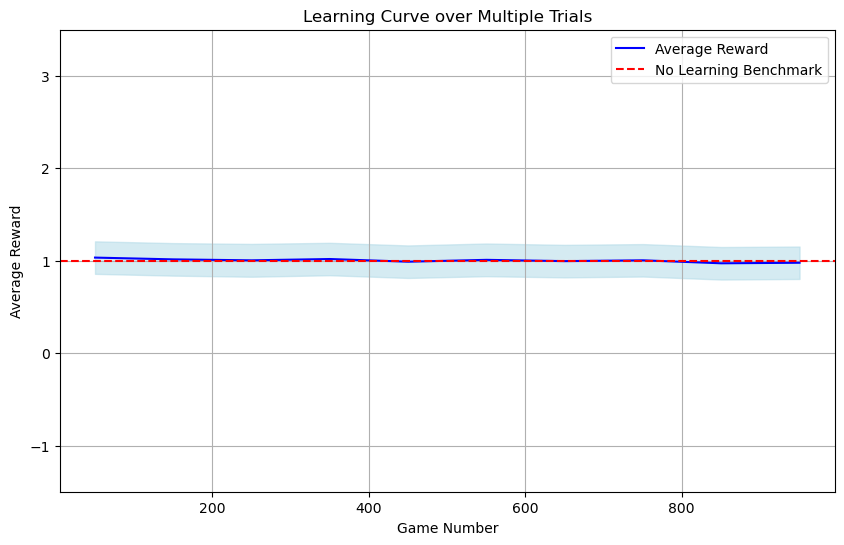

In [23]:
num_trials = 100
games_per_trial = 1000
player1 = RandomPlayer()
player2 = RandomPlayer()
results = run_trials(num_trials, games_per_trial, player1, player2)
plot_learning_curve(results)

### Step 8: Writing MENACE

Finally, we're ready to implement MENACE! We will create a MenacePlayer class. The constructor takes an argument, `initial_beads`, that specifies how many beads (for each move) are placed in the matchboxes at the start. 

<font color="red">

**NOTE:**
We do **not** handle symmetric boards. That is, the real MENACE method treats two equivalent (but different) boards as being the same matchbox. For example, a board with only an X in the top-left and a board with only an X in the top-right are effectively the same, and a single matchbox could be used to handle both of these game states. Without accounting for these symmetric game states, there are roughly 20,000 possible boards in tic-tac-toe. Accounting for symmetries, the number of possible states can be reduced to just 304! Because our implementation does not account for these symmetries, it must effectively learn the right behavior for the "same" position many times independently. This will make our implementation much slower to learn than the real MENACE.



In [25]:
class MenacePlayer:
    def __init__(self, initial_beads):
        self.initial_beads = initial_beads # The number of beads of each color to add at the start of each trial (here, and when reset is called)
        ### TODO: ENTER YOUR CODE HERE
        
        self.matchboxes ={} #should this be a dict within a dict?/ maybe consider helper? 
        self.log = []

    def reset(self):
        ### TODO: ENTER YOUR CODE HERE. This function should completely reset the MenacePlayer so that it is as though it was a fresh new player
        self.matchboxes ={}
        self.log =[]
        #pass

    def get_move(self, board, symbol):
        ### TODO: ENTER YOUR CODE HERE. Note that you'll need to store the boards and moves until the learn function is called at the end of the game
        ### NOTE: Our solution does not reference `symbol`.
        ### NOTE: The code below is for selecting a random move and should be replaced
        valid_movesp = valid_moves(board)
        #return random.choice(moves)
        key = self.matchbox_key(board)
        
        if key not in self.matchboxes:
            self.matchboxes[key] = {move: self.initial_beads for move in valid_movesp}
        
        box = self.matchboxes[key]
        move_choices=[]
        weigths =[]
        for move in valid_movesp:
            weight = box.get(move,0)
            if weight>0:
                move_choices.append(move)
                weigths.append(weight)
        if len(move_choices) == 0:
            chosen_move = random.choice(valid_movesp)
        else:
            chosen_move = random.choices(move_choices, weights=weigths, k=1)[0]

        self.log.append((key,chosen_move))
        return chosen_move

    def learn(self, result, symbol):
        ### TODO: ENTER YOUR CODE HERE.
        ### NOTE: Our solution does not reference `symbol`.
        ### NOTE: To avoid errors, either do not allow the last bead to ever be removed from a matchbox or ensure that having an empty matchbox is properly handled
        ### NOTE: If you're storing a log of the game in get_move calls and using it here, don't forget to clear that log at the end of this function!
         
        if result == 'Win':
            reward = 3
        elif result == 'Draw':
            reward = 1
        else: 
            reward = -1
        #pass
        for key, move in self.log: 
            box = self.matchboxes[key]
            new_count = box[move] + reward
            if new_count < 1:
                new_count = 1
            box[move] = new_count
            
        self.log = []  

    ### TODO: YOU MAY DEFINE ADDITIONAL HELPER FUNCTIONS HERE.
    def matchbox_key(self, board):
        key = 0
        multiplier = 1
        for row in board:
            for cell in row:
                value = {' ': 0, 'X': 1, 'O': 2}.get(cell, 0)
                key += value * multiplier
                multiplier *= 3
        return key  
        

### Step 9: Results!

Let's see how MENACE does against the random opponent! 

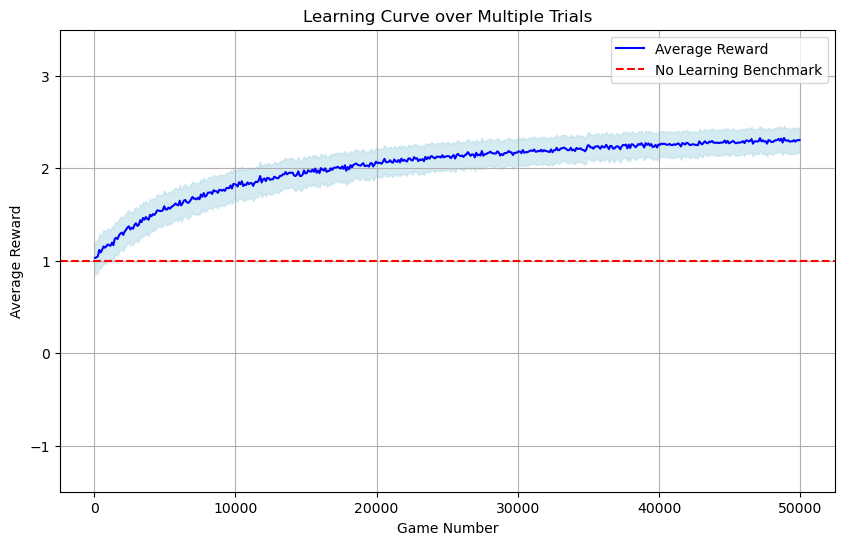

In [27]:
num_trials = 100
games_per_trial = 50000
player1 = MenacePlayer(3)
player2 = RandomPlayer()
results = run_trials(num_trials, games_per_trial, player1, player2)
plot_learning_curve(results)